# 课题：**深度学习应用于拉曼光谱官能团识别**  
*Deep learning for fuctional group identification using Raman spectra.*

本课题利用深度学习模型，根据有机分子的拉曼光谱，识别分子中存在的官能团。
## 目录

# 1 配置虚拟环境 
>**如果你已经配置过其他拥有torch的环境，激活该环境后跳到(5)即可。**

(1) 打开终端 
 
(2) 新建环境  
```
conda create -n fgid python=3.10
```
(3) 进入环境
```
conda activate fgid
```
(4) 安装所需包
```
pip install -r requirements.txt
```
(5) 安装rdkit  
rdkit是用来对化学分子进行结构展示、性质计算等操作的开源工具包。我们将使用rdkit展示分子结构式。 
```
pip install rdkit-pypi==2022.9.4
```

# 2 数据准备
## 2.1 定义随机种子
深度学习涉及较多的随机过程，例如抽样、参数初始化等，导致每次运行结果都不同。随机种子可以让程序拥有“记忆”，通过设置随机种子为一个固定值，可以使程序每次运行后输出同样的结果，便于查看和分析。

In [1]:
import numpy as np
import os, torch, random
SEED = 42 # 也可以设置别的数，设置后保持不变即可。

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

d:\anaconda3\envs\fgid\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\anaconda3\envs\fgid\lib\site-packages\torch\random.py:42: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  return default_generator.manual_seed(seed)


## 2.2 载入数据集

In [2]:
dataset = np.load('data/data.npz')
data = dataset['data'] # 光谱数据
label = dataset['label'] # 标签，1表示官能团存在，0表示不存在。
smiles = dataset['smiles']

我们将对10种官能团进行识别，按照先后顺序对应标签 ```y``` 的10个维度，名称如下（注意，为了减少计算量，此处只选择了10个官能团，分子中可能有其他官能团）。

In [3]:
label_names = [
        'Alkane',
        'Alkene',
        'Alkyne',
        'Arene',
        'Haloalkane',
        'Alcohol',
        'Aldehyde',
        'Ketone',
        'Ester',
        'Ether',
]

查看数据集中的分子结构式和存在的官能团：

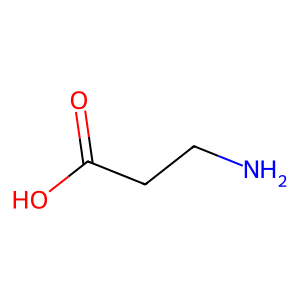

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
smiles = 'NCCC(=O)O'
mol = Chem.MolFromSmiles(smiles)
img =Draw.MolToImage(mol)
img

## 2.3 数据集的划分
我们采用分层抽样，将数据集划分成数量比为训练:验证:测试=3:1:1的三个子集，保证每种官能团在各个子集里的数量占比与在全集中相同（实际情况下不可能完全均分，所以取整作近似）。

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

shuffle_splits = 1
# 定义分层抽样器1，使测试集占全集20%。test_size=1/(1+1+3)=0.2
str_shuffle_1 = MultilabelStratifiedShuffleSplit(n_splits=shuffle_splits, test_size=0.2, random_state=SEED)
# 定义分层抽样器2，使验证集占剩训练+验证数据的25%。test_size=1/(1+3)=0.25
str_shuffle_2 = MultilabelStratifiedShuffleSplit(n_splits=shuffle_splits, test_size=0.25, random_state=SEED) 

for train_val_index, test_index in str_shuffle_1.split(data, label):
    X_train_val = data[train_val_index]
    X_test = data[test_index]
    y_train_val = label[train_val_index]
    y_test = label[test_index]
    smiles_train_val = smiles[train_val_index]
    smiles_test = smiles[test_index]
for train_index, val_index in str_shuffle_2.split(X_train_val, y_train_val):
    X_train = X_train_val[train_index]
    X_val = X_train_val[val_index]
    y_train = y_train_val[train_index]
    y_val = y_train_val[val_index]
    smiles_train = smiles_train_val[train_index]
    smiles_val = smiles_train_val[val_index]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6507, 500), (6507, 10), (2169, 500), (2169, 10), (2170, 500), (2170, 10))

# 2.4 构建Dataloader

In [6]:
from torch.utils.data import DataLoader, TensorDataset
def get_dataloader(X, y, batch_size=64):
    '''
    将光谱X和标签y配对并分为len(X)/batch_size个批次，每批次batch_size个光谱-标签对。'''
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    dataset = TensorDataset(X, y)
    # weighted_sampler = sampler.WeightedRandomSampler(sampling_weight, len(sampling_weight))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

train_loader = get_dataloader(X_train, y_train, batch_size=128)
val_loader = get_dataloader(X_val, y_val, batch_size=64)


# 3 训练模型
## 3.1 训练组件设置
(1) 使用gpu加速  
>如果下面代码输出cpu但是你的电脑有gpu，可以参考教程：[选择正确版本的CUDA和PyTorch安装](https://zhuanlan.zhihu.com/p/672526561)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device # 查看在使用的处理器

device(type='cpu')

(2) 早停机制  
选择一个监测指标，在每次迭代后检查该指标：如果该指标提升，保存模型参数；在该指标连续几次迭代（次数可选）不升高后，自动停止训练以防止过拟合：

In [8]:
class EarlyStopping:
    def __init__(self, save_path, patience=5, delta=0):
        """
        Args:
            save_path: 模型参数保存路径.
            patience (int): 监测指标在连续patience次迭代不升高后，自动停止训练。
                            Default: 5
            delta (float): 监测指标增量小于该值时，不保存模型。
                            Default: 0
        """
        self.save_path = save_path
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} / {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        path = os.path.join(self.save_path, 'best_network.pth')
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

## 3.2 设置训练参数和模型初始化

In [9]:
from model import CNN
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from tqdm import tqdm
from time import time

num_epochs = 100 # 最大迭代次数
model_save_path = 'model_path' # 保存模型参数的路径
learning_rate = 2.5e-4 # 学习率
val_threshold = 0.5 # 该阈值用来与模型计算的官能团存在概率作比较，若概率值大于该阈值，认为官能团存在，输出标签的相应维度上元素输出为1，否则为0。
model = CNN(class_num=y_train.shape[1]).to(device)
'''
pos_weight=? 为每类官能团的loss赋予权重，是否可以提高模型性能？'''
criterion = BCEWithLogitsLoss()
optimizer = Adam(params=model.parameters(), lr=learning_rate)


## 3.3 训练和验证

In [10]:
val_loss_list = []
train_loss_list = []
val_loss_min = 1

earlystopping = EarlyStopping(save_path=model_save_path)
val_acc_max = 0.5

time_start = time()
for epoch in range(1, num_epochs+1):

# 训练
    train_loss = 0
    model.train()
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=50)
    for _, (batch_x, batch_y) in train_bar:
        optimizer.zero_grad()
        outputs = model(batch_x.to(device))
        loss = criterion(outputs, batch_y.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    print(f'Epoch [{epoch}/{num_epochs}], Training Loss: {train_loss}.')

# 验证
    model.eval()
    val_loss = 0
    val_acc = 0
    num_correct = 0
    with torch.no_grad():
        val_bar = tqdm(enumerate(val_loader), total=len(val_loader), ncols=50)  # 创建进度条
        for _, (batch_x, batch_y) in val_bar:
            val_outputs = model(batch_x.to(device))
            loss = criterion(val_outputs, batch_y.to(device))
            optimizer.zero_grad()
            predicted_labels = (val_outputs >= val_threshold).float().cpu()
            num_correct += np.count_nonzero(predicted_labels == batch_y)
            val_loss += loss.item()

    val_acc = num_correct/(y_val.shape[0]*y_val.shape[1]) 
    val_loss = val_loss / len(val_loader)
    print(f'Epoch [{epoch }/{num_epochs}], Validation Accuracy: {val_acc}.')

    if earlystopping:
        earlystopping(val_loss, model)
        if earlystopping.early_stop:
            print("Early stopped.")
            time_end=time()
            break
print(f'Total training time: {(time_end-time_start)//60} mins.')

 43%|█████▌       | 22/51 [00:07<00:09,  3.11it/s]

: 

: 

# 4 测试
## 4.1 载入模型参数和测试集

In [ ]:
model = CNN(class_num=y_test.shape[1])
model.load_state_dict(torch.load('model_path\\best_network.pth', map_location=device),
                                                          strict=False)
test_loader = get_dataloader(X_test, y_test, batch_size=128)

In [ ]:
test_bar = tqdm(enumerate(test_loader), total=len(test_loader), ncols=50)  # 创建进度条
num_correct
y_predicted = []
for _, (batch_x, batch_y) in test_bar:
    test_outputs = model(batch_x.to(device))
    loss = criterion(test_outputs, batch_y.to(device))
    optimizer.zero_grad()
    predicted_labels = (test_outputs >= val_threshold).float().cpu().numpy()
    num_correct += np.count_nonzero(predicted_labels == batch_y)
    y_predicted.append(predicted_labels)
y_predicted = np.vstack(y_predicted)

## 4.2 模型性能可视化  
**性能指标：**

精确率、召回率、F1分数      
        精确率 $Precision = \frac{TP(真阳性)}{TP(真阳性)+FP(假阳性)}$   
        召回率 $Recall = \frac{TP}{TP+FN(假阴性)}$      
        F1分数 $F1-Score = 2\times\frac{Precision \times Recall}{Precision + Recall}$   

(1) 各类官能团识别结果汇总 
     
下面的函数中包含以下内容：      
第1列：官能团索引号     
第2~4列：按官能团统计的指标     

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_predicted, digits=4, zero_division=0))
print('完全匹配率：{:.2f}%'.format(metrics.accuracy_score(y_test, y_predicted)*100))

上述指标中：    

```support```是各类官能团在测试集里的数量。        

```micro avg```微观平均，是以输出标签的单个元素为单位统计$TP、FP$和$FN$后计算的上述性能指标。    

```macro avg```宏观平均，表示各官能团性能指标的算术平均值。 

```weighted avg```加权平均，是按照各个官能团的```support```加权的平均值。   

```samples avg``` 样本平均，是以输出标签为单位统计$TP、 FP$和$FN$后计算所有样本的各项指标的平均值。

```完全匹配率```表示所有10个元素全部预测正确的标签占所有测试样本的比例。

**直观理解：**
> **模型的真实标签和预测标签分别构成两个矩阵，它们形状相同，每行代表一个分子中官能团的存在情况，每列代表一种官能团在整个数据集中的存在情况；比较两个矩阵，可以分析模型识别性能的好坏。```micro avg```是对元素进行逐一比较汇总后计算指标，```macro avg```是比较对应列的各元素、计算每一列指标后求算术平均，```weighted avg```是按照每一列上“1”的个数求列指标的加权平均，```samples avg```是比较对应行的各元素、计算每一行指标后求算术平均。**

(2) 下面的函数```plot_result```计算了各类官能团的精确率、召回率和F1分数，并按照官能团在测试集中的数量从少到多展示。

In [ ]:
import matplotlib.pyplot as plt
def plot_result(y_true, y_pred, label_list):
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred)
    support = support / 2
    # Sort the support array and get the sorted indices
    sorted_indices = support.argsort()

    # Rearrange the arrays based on sorted indices
    sorted_support = support[sorted_indices][::-1]
    sorted_precision = precision[sorted_indices][::-1]
    sorted_recall = recall[sorted_indices][::-1]
    sorted_f1 = f1[sorted_indices][::-1]
    sorted_labels = [label_list[i] for i in sorted_indices][::-1]

    # Create a figure and axis
    _, ax1 = plt.subplots(figsize=(9,4))

    # Plot 'a' and 'b' as line charts on the primary Y-axis (ax1)
    ax1.plot(sorted_labels, sorted_precision, label='Precision', color='blue', marker='o')
    ax1.plot(sorted_labels, sorted_recall, label='Recall', color='green', marker='s')
    ax1.plot(sorted_labels, sorted_f1, label='F1-score', color='red', marker='x')

    # Set labels for the primary Y-axis
    ax1.set_xlabel('Labels')
    ax1.set_ylabel('Values', color='black')

    # Create a secondary Y-axis for the histogram 'c'
    ax2 = ax1.twinx()
    ax2.bar(sorted_labels, sorted_support, color='red', alpha=0.6, width=0.4)

    # Set labels for the secondary Y-axis
    ax2.set_ylabel('Label Frequency', color='black')
    ax1.set_xticklabels(sorted_labels, rotation=90, ha='right')
    ax1.grid()

    # Add a legend
    ax1.legend(loc = 1, bbox_to_anchor=(0.5, 0.70))
    ax2.legend(['Frequency'], loc = 1, bbox_to_anchor=(0.5, 0.40))

    # Show the plot
    plt.title('Performance to class distribution')
    plt.tight_layout()
    plt.show()

In [ ]:
plot_result(y_test, y_predicted, label_list=label_names)

## 4.3 结果讨论
通过上面的结果可以发现：
    
* 数据集里不同官能团的数量不同。

* 数量多的官能团容易被识别，数量少的则相反，表现为召回率较低 。 
    >**如果某种官能团存在于分子中（即实际标签为1），但是没有被识别出来（即模型预测为0），那么会导致假阴性数量$FN$偏高，导致召回率偏低）。**     

* 有的官能团即使数量较多，也难以被识别，例如醚键（Ester）。考虑到醚键的召回率低，酯基（Ester）的精确率低，而二者有存在相同的化学键```C-O```，对应相同的振动模式，可能存在位置、强度和形貌相近的谱峰，因此推测模型把大量的醚键误认为是酯基，导致醚键假阴性数量多，召回率低，而酯基假阳性数量多，精确率低。